#### Курсовой проект по по курсу "Python для Data Science"

#### Cлушатель: Перфильев Дмитрий

#### Задание:

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


#### Решение:

Загружаем необходимые библиотеки. Устанавливаем настройки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score as r2

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Загрузим данные из файла data_train.csv по которым построим модель. 

In [2]:
data_train = pd.read_csv('DATA/train.csv', sep=',')
data_train.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

Разобьем данные на тренеровочные (data_train) на которых будем обучать модель и на валидационные (valid) по которым будем предскаpывать цену и оценивать модель

In [3]:
####train, valid = tts(data_data_train, test_size=0.3, random_state=22)
####train.shape, valid.shape

Оценим качество данных. Произведем первичную обработку данных.

Оценим количество отсутствующих полей

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Поле Healthcare_1 имеет значительное количество пропущенных полей почти половины от общего числа (3666 из 7000) имеет смысл удалить данный признак из данных. Если модель без данного признака не будет показывать положительных результатов постараемся восстановить денный признак.

In [5]:
data_train = data_train.drop('Healthcare_1', axis=1)

In [6]:
data_train.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3   Helthcare_2       Shops_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      24.687000   5352.157400      8.039200      1.319500      4.231300   
std       17.532614   4006.799803     23.831875      1.493601      4.806341   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000      0.000000      1.000000   
50%       25.000000   5285.000000      2.000000      1.000000      3.000000   
75%       36.000000   7227.000000      5.000000      2.000000      6.000000   
max       74.000000  19083.000000    141.000000      6.000000     23.000000   

               Price  
count   10000.000000  
mean   214138.857399  
std     92872.293865  
min     59174.778028  
25%    153872.633942  
50%    192269.644879  
75%    249135.462171  
max    633233.466570

Преобразуем категориальные признаки Ecology_2 Ecology_3  

In [7]:
data_train = pd.get_dummies(data_train)

In [8]:
data_train.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
0         9.0       1969   0.089040  ...         5            0       11   
1         9.0       1978   0.000070  ...         1            1       16   
2        12.0       1968   0.049637  ...         0            1        3   
3        17.0       1977   0.437885  ...         3            0        5   
4        12.0       1976   0.012339  ...         1            2        4   

           Price  Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  \
0  184966.930730            0            1            0            1   
1  300009.450063            0            1            0            1   
2  220925.908524            0            1            0            1   
3  175616.227217            0            1            0            1   
4  150226.531644            0            1            0            1   

   Shops_2_A  Shops_2_B  
0          0          1  
1          0          1  
2          0          1  
3          0          1  
4          0          1  

[5 rows x 22 columns]

In [9]:
data_train.shape

(10000, 22)

Преобразуем поле HouseYear - вычислим возраст домов


In [10]:
data_train.loc[2019 - data_train['HouseYear'] < 0,'HouseYear']

585         2020
707         2020
790         2020
918         2020
1497    20052011
1499        2020
2493        2020
2877        2020
3357        2020
3485        2020
3859        2020
4053        2020
4189        4968
4376        2020
4493        2020
5701        2020
6735        2020
7076        2020
7459        2020
8253        2020
9674        2020
Name: HouseYear, dtype: int64

In [11]:
data_train.loc[data_train['HouseYear'] == 20052011,'HouseYear'] = 2011
data_train.loc[data_train['HouseYear'] == 4968,'HouseYear'] = 1968

In [12]:
data_train.loc[2019 - data_train['HouseYear'] < 0,'HouseYear']

585     2020
707     2020
790     2020
918     2020
1499    2020
2493    2020
2877    2020
3357    2020
3485    2020
3859    2020
4053    2020
4376    2020
4493    2020
5701    2020
6735    2020
7076    2020
7459    2020
8253    2020
9674    2020
Name: HouseYear, dtype: int64

In [13]:
data_train.loc[2019 - data_train['HouseYear'] > 100,'HouseYear']

910     1914
1380    1917
1386    1918
2554    1918
2656    1912
2902    1918
5016    1918
5053    1917
5111    1912
7611    1916
8144    1917
8505    1918
9317    1910
Name: HouseYear, dtype: int64

In [14]:
data_train['HouseYear'] = 2019 - data_train['HouseYear']

In [15]:
data_train['HouseYear'].describe()

count    10000.000000
mean        34.133700
std         18.412271
min         -1.000000
25%         18.000000
50%         42.000000
75%         45.000000
max        109.000000
Name: HouseYear, dtype: float64

Оценим данные в колнках Rooms Square LifeSquare KitchenSquare

Заменим пустые поля колонки LifeSquare значениями поля колонки Square

In [16]:
data_train['LifeSquare'] = data_train['LifeSquare'].fillna(data_train['Square'])

In [17]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

Rooms        Square    LifeSquare  KitchenSquare          Price
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000
mean       1.890500     56.315775     42.091874       6.273300  214138.857399
std        0.839512     21.058732     77.880874      28.560917   92872.293865
min        0.000000      1.136859      0.370619       0.000000   59174.778028
25%        1.000000     41.774881     25.506959       1.000000  153872.633942
50%        2.000000     52.513310     37.562685       6.000000  192269.644879
75%        2.000000     65.900625     50.098049       9.000000  249135.462171
max       19.000000    641.065193   7480.592129    2014.000000  633233.466570

In [18]:
data_train.loc[data_train['Square'] < data_train['LifeSquare'],['Square','LifeSquare']].head()

Square  LifeSquare
28    42.530043   43.967759
44   104.211396  106.340403
52    61.400054   65.224603
123   85.952306   89.803753
153   51.831473   53.491301

Поменняем местами поля колонок LifeSquare и Square там где Square < LifeSquare

In [ ]:
# life_square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'LifeSquare'].copy()
# square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Square'].copy()

# id_sq = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Id']

# (data_train.loc[id_sq.index,'Square'] , data_train.loc[id_sq.index,'LifeSquare']) = (life_square, square)

Выберем и обработаем колонку Rooms с нулевым значением. 

In [ ]:
data_train.loc[data_train['Rooms'] == 0,['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']]

Rooms      Square  LifeSquare  KitchenSquare          Price
1397    0.0  138.427694  136.215499            0.0  268394.744389
1981    0.0  212.932361  211.231125            0.0  302211.260887
2269    0.0   41.790881   41.790881            0.0   98129.976788
3911    0.0   49.483501   49.483501            0.0  217009.338463
4366    0.0   81.491446   81.491446            0.0  212864.799112
4853    0.0    2.377248    0.873147            0.0  126596.941798
6149    0.0   38.697117   19.345131            9.0  158998.110646
8834    0.0   87.762616   85.125471            0.0  219281.918007

In [ ]:
data_train.loc[data_train['Rooms'] == 0,'Rooms'] = round(data_train['Square'] / (data_train.loc[data_train['Rooms'] != 0,'Square']/data_train.loc[data_train['Rooms'] != 0,'Rooms']).mean())

Заменим данные в строке 4853 средними значениями 

In [ ]:
data_train.loc[4853,['Rooms','Square','LifeSquare']] = [round(data_train['Rooms'].std()) , 
                                                        data_train['Square'].std(),
                                                        data_train['LifeSquare'].std()]

In [ ]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

Rooms        Square    LifeSquare  KitchenSquare          Price
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000
mean       1.892700     56.317643     42.099575       6.273300  214138.857399
std        0.839915     21.054775     77.880605      28.560917   92872.293865
min        1.000000      1.136859      0.370619       0.000000   59174.778028
25%        1.000000     41.774881     25.527399       1.000000  153872.633942
50%        2.000000     52.513310     37.569515       6.000000  192269.644879
75%        2.000000     65.900625     50.133005       9.000000  249135.462171
max       19.000000    641.065193   7480.592129    2014.000000  633233.466570

Построим диаграммы для оценки данных

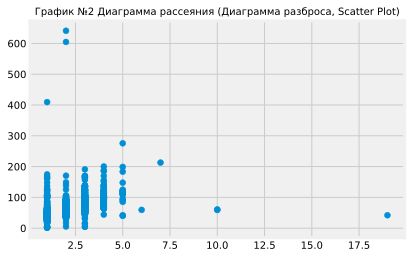

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

Отсечем экстремальные значения

In [ ]:
data_train.loc[(data_train['Rooms'] == 3) & (data_train['Square'] > 7000),:] 

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Social_1, Social_2, Social_3, Helthcare_2, Shops_1, Price, Ecology_2_A, Ecology_2_B, Ecology_3_A, Ecology_3_B, Shops_2_A, Shops_2_B]
Index: []

[0 rows x 22 columns]

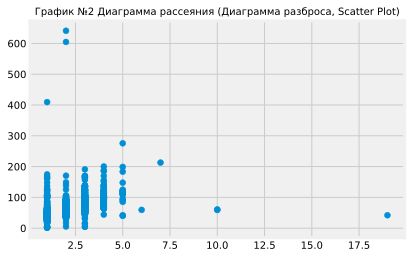

In [ ]:
data_train.loc[(data_train['Rooms'] == 3) & (data_train['Square'] > 7000),'Square'] = data_train['LifeSquare']
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * 80,'Square'] = data_train['Rooms'] * 80

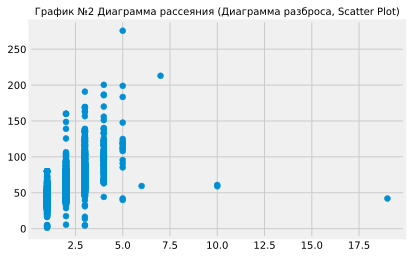

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Rooms'] == 5, :]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1422   4282         195    5.0   95.617533   62.377052            7.0      7   
1503   1243          86    5.0  108.057398   82.723825            8.0      3   
1982   5548          86    5.0  275.645284  233.949309           26.0     12   
3268   8901          34    5.0  121.577423  114.913843            1.0     25   
3271   6358          27    5.0   42.003293   42.003293            0.0      5   
4431   7594          53    5.0   39.906082   39.394024            1.0      5   
4487  13434          13    5.0  183.382273  100.985505           15.0      2   
4762   4070          21    5.0  114.313752   88.492650            9.0      6   
5361   2879          78    5.0  118.871952   69.023509           10.0     15   
5466   3454           8    5.0  112.135525   79.795451           10.0      4   
6623   3294         167    5.0  111.045799   81.940459            9.0      6   
6988   8685          62    5.0  124.933289   81.122369           30.0      5   
8511   4249          23    5.0  198.930182  123.139863           10.0      1   
8659  14143          13    5.0  119.008007   69.033727           11.0     13   
8726    238          88    5.0   90.762276   70.991790            5.0      1   
8925   4214         105    5.0   85.313605   56.686693            5.0      4   
9432    338          46    5.0  147.709302  147.709302            0.0      6   
9699   4971         169    5.0  117.855969   76.561318            9.0     12   

      HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
1422         7.0         79   0.015017  ...        59            0        8   
1503         5.0         77   0.161976  ...         5            3        7   
1982        37.0          8   0.161976  ...         5            3        7   
3268         1.0         42   0.069753  ...         4            1       11   
3271        12.0         42   0.011654  ...         0            0        0   
4431         1.0         42   0.049637  ...         0            1        3   
4487         6.0         22   0.090799  ...         2            5       15   
4762         5.0         59   0.034331  ...         3            0        4   
5361        16.0         21   0.092291  ...         2            1        2   
5466        17.0         20   0.437885  ...         3            0        5   
6623         6.0         79   0.050272  ...        14            0        3   
6988         3.0          2   0.072158  ...         1            0        0   
8511         2.0          8   0.014073  ...         0            0        0   
8659        17.0         18   0.090799  ...         2            5       15   
8726         9.0         47   0.127376  ...         3            3        9   
8925        12.0         52   0.040243  ...        11            3        1   
9432         0.0         42   0.150818  ...         4            4        5   
9699        14.0         18   0.178917  ...         4            1        5   

              Price  Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  \
1422  479525.147323            0            1            0            1   
1503  310305.074733            0            1            1            0   
1982  455264.882666            0            1            1            0   
3268  455446.393758            0            1            0            1   
3271  112693.641769            0            1            0            1   
4431  206148.845716            0            1            0            1   
4487  622888.825328            0            1            0            1   
4762  499830.937577            0            1            0            1   
5361  496026.671162            0            1            0            1   
5466  471833.787538            0            1            0            1   
6623  513239.499082            0            1            0            1   
6988  271919.866048            0            1            0            1   
8511  34566

In [ ]:
data_train.loc[data_train['Square'] < data_train['Rooms'] * 20, 'Square'] = data_train['Rooms'] * 30
data_train.loc[data_train['Square'] < data_train['Rooms'] * 20, 'Square'] = data_train['Rooms'] * 30

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Rooms'] == 5, :]

In [ ]:
data_train.loc[(data_train['Rooms'] == 1) & (data_train['Square'] > 100),:] 

In [ ]:
plt.scatter(data_train['Rooms'],data_train['LifeSquare'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Square'] == max(data_train['Square']),:]

In [ ]:
# data_train.loc[data_train['Rooms'] > raund(data_train['Rooms']/Square]

In [ ]:
data_train.loc[data_train['Square'] < data_train['LifeSquare'],:].head()

In [ ]:
life_square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'LifeSquare'].copy()
square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Square'].copy()

id_sq = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Id']

(data_train.loc[id_sq.index,'Square'] , data_train.loc[id_sq.index,'LifeSquare']) = (life_square, square)

In [ ]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

In [ ]:
data_train.loc[153]

In [ ]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * data_train['Square'].mean(),'Rooms']

In [ ]:
data_train.loc[data_train['Rooms'] > 3,:]

In [ ]:
data_train.loc[data_train['HouseYear'] < 0, :]

In [ ]:
data_train.loc[data_train['HouseYear'] > 100, :]

In [ ]:
data_train['Ecology_3'].value_counts()

In [ ]:
df_test = pd.read_csv('DATA/test.csv', sep=',')
df_data_train.head()
df_data_train['Ecology_2'].value_counts()

In [ ]:
data_train.loc[data_train['LifeSquare'].isnull(),:].head()

In [ ]:
data_train.describe()

In [ ]:
data_train.loc[data_train['Healthcare_1'].isnull(),:].head()

In [ ]:
df_test = pd.read_csv('DATA/test.csv', sep=',')
df_data_train.head()

In [ ]:
df_test.head()

In [ ]:
df_data_train.info()

In [ ]:
df_data_train.columns

In [ ]:
df_target_data_train = pd.DataFrame(df_data_train['Price'], columns=['Price'])

In [ ]:
df_target_data_train.head()

In [ ]:
df_data_train.describe()